# <font color="Blue">Core-halo mass relations of fuzzy dark matter </font>

In [1]:
import numpy as np
import time
from scipy.integrate import quad
from scipy import linalg
from scipy import sparse
from scipy import special
from scipy import optimize
from scipy import integrate
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import scipy.special as scp
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator)

## <font color="Red">Get eigenvalues of soliton core (ground state) </font>

### Get eigenvalues, $\mathcal{E}/\alpha$, numerically

In [2]:
### Potential of S-P equation in a fixed halo (NFW profile)

def V_pot(alpha,ell,x):
    return -alpha * np.log(1+x)/x + ell*(ell+1)/x**2
vect_V_pot = np.vectorize(V_pot)

### Evaluating energy eigenvalues by numerically solving linear eigenvalue problem

def Enalpha(alpha0,ell):
    xmin = 0
    xmax = 1e4/np.sqrt(alpha0)
    delta = (xmax-xmin)/ngrid
    dim = ngrid - 1 # Number of internal points
    x = np.linspace(xmin+delta,xmax-delta,dim)

    h = np.zeros((dim,dim),float)
    for i in range(len(h)-1):
        h[i,i+1] = h[i+1,i] = -1/delta**2 
    for i in range(len(h)):
        h[i,i] = 2./delta**2 + V_pot(alpha0,ell,x[i])
    vals0, vecs0 = linalg.eigh(h)
    return vals0[0]/alpha0

vect_Enalpha = np.vectorize(Enalpha)

In [3]:
### Caution !!!  This will take time (~ few min).  
###
### If you have already run, you can skip this cell, 
### and just download the files below (see the next cell).

ell0    = 0
ngrid   = 2000 # Number of intervals
nsample = 100

print("This takes several minutes. Run? y or n")
str_test = input()

if(str_test=="y"):
    start = time.time()

    arr_alpha0 = np.logspace(-5,20, num=nsample)
    arr_Enalpha = vect_Enalpha(arr_alpha0, ell0)
    func_Enalpha = interp1d(np.log(arr_alpha0),arr_Enalpha)

    print("ngrid = ",ngrid,", nsample = ",nsample)
    print("{:f}".format((time.time() - start)/60.0)+" min")

    directory = "/Users/ataruya/Files/Lin/work_space/FDM/data_JupyterNB/"
    np.save(directory + "alpha0",arr_alpha0)
    np.save(directory + "E1alpha",arr_Enalpha)
else:
    print("Nothing has done. Thanks !! ")
    

This takes several minutes. Run? y or n


 n


Nothing has done. Thanks !! 


In [3]:
### Load pre-computed data ###

directory = "/Users/ataruya/Files/Lin/work_space/FDM/data_JupyterNB/"
arr_alpha0 = np.load(directory + "alpha0.npy")
arr_Enalpha = np.load(directory + "E1alpha.npy")

func_Enalpha = interp1d(np.log(arr_alpha0),arr_Enalpha)

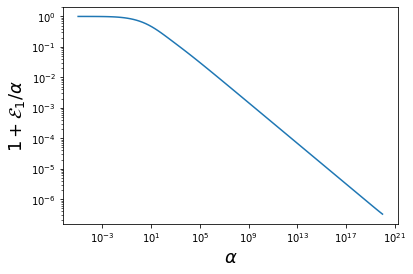

In [4]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(-1,0.)

ax.plot(arr_alpha0,1+arr_Enalpha)

ax.set_xlabel("$\\alpha$",fontsize=18)
ax.set_ylabel("$1 + \\mathcal{E}_{1}/\\alpha$",fontsize=18)
ax.plot()

plt.show()

### Get eigenvalues, $\mathcal{E}/\alpha$, analytically

In [5]:
def ffint(eps):
    g= lambda x: np.log(1+x)/x + eps
    if  eps > -0.2:
        xmax = 10000000
    else:
        xmax = 1000000
        eps1 = -0.1
    sol = optimize.brentq(g, 0.00000001, xmax, maxiter=500)
    return integrate.quad(lambda x: np.sqrt(g(x)), 0, sol, limit=500)[0]

def wave_func_at_zero(alpha,eps): 
    z_zero = -alpha**(1./3.)*(1.5*ffint(eps))**(2./3.)
#    sol = optimize.brentq(special.airy(z_zero)[0], -0.999, -0.3)
    return special.airy(z_zero)[0]

def solve_eigenvalue1(alpha, epsmin, epsmax): 
    hh = lambda eps: wave_func_at_zero(alpha, eps)
    sol = optimize.brentq(hh, epsmin, epsmax)
    return sol

def get_eigenvalues(alpha, nmax, eps_init):
    evalues=np.zeros(nmax)
    i=0
    eps1 = eps_init
    if  alpha<1e-4:
        delta_eps = 0.00025
        eps1 = -0.1
    elif  alpha>=1.e-4 and alpha<1.e-3:
        delta_eps = 0.001
        eps1 = -0.2
    elif  alpha >= 1.e-3 and alpha<1:
        delta_eps = 0.01
        eps1 = -0.4
    elif alpha >= 1e4 and alpha<1e6:
        delta_eps = 0.001
        eps1 = -0.999
    elif alpha >= 1e6 and alpha<1e8:
        delta_eps = 0.001
        eps1 = -0.99999
    elif alpha >= 1e8 and alpha < 1e10:
        delta_eps = 0.0005
        eps1 = -0.99999
    elif alpha >= 1e10 and alpha < 1e12:
        delta_eps = 0.0001
        eps1 = -0.99999
    elif alpha >= 1e12 and alpha < 1e15:
        delta_eps = 0.00001
        eps1 = -0.99999
    elif alpha >= 1e15 and alpha < 1e17:
        delta_eps = 0.000001
        eps1 = -0.9999999
    elif alpha >= 1e17 and alpha <= 1e20:
        delta_eps = 0.0000001
        eps1 = -0.9999999
    else:
        delta_eps = 0.01
        
    wf1 = wave_func_at_zero(alpha, eps1) 
    while(i < nmax):
        eps2 = eps1 + delta_eps / (i+1)    # increasing the resolution by dividing the factor of (i+1)
        wf2 = wave_func_at_zero(alpha, eps2)
        if wf1*wf2<0.:
            evalues[i]=solve_eigenvalue1(alpha, eps1, eps2)
            i+=1
        eps1 = eps2
        wf1 = wf2
    return evalues

def get_ground_state_eigenvalue(alpha, eps_init):
    return get_eigenvalues(alpha, 1, eps_init)[0]

get_E0 = np.vectorize(get_ground_state_eigenvalue)

In [6]:
ngrid = 2000 # Number of intervals
nsample = 100

arr_alpha0 = np.logspace(-5,20, num=nsample)
arr_Enalpha_ana1 = get_E0(arr_alpha0,-0.999)
arr_Enalpha_ana2 = -1 + arr_alpha0**(-1/3)*(9*np.pi/16)**(2/3)

/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/3406815409.py:9: RuntimeWarning: invalid value encountered in sqrt
  return integrate.quad(lambda x: np.sqrt(g(x)), 0, sol, limit=500)[0]
/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/3406815409.py:9: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: np.sqrt(g(x)), 0, sol, limit=500)[0]


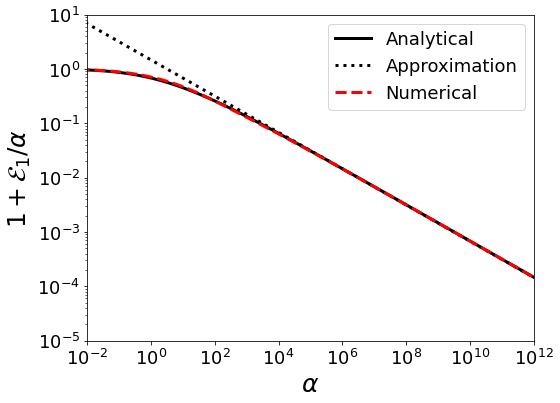

In [7]:
plt.rcParams["font.size"] = 25
fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1,1,wspace=0.0,hspace=0.0)

ax = plt.subplot(gs[0,0])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-2,1e12)
ax.set_ylim(1e-5,1e1)

ax.plot(arr_alpha0,1+arr_Enalpha_ana1, lw=3, ls='-', c='black', label="Analytical")
ax.plot(arr_alpha0,1+arr_Enalpha_ana2, lw=3, ls=':', c='black', label="Approximation")
ax.plot(arr_alpha0,1+arr_Enalpha, lw=3, ls='--', c='red', label="Numerical")

ax.set_xlabel("$\\alpha$",fontsize=25)
ax.set_ylabel("$1 + \\mathcal{E}_{1}/\\alpha$",fontsize=25)
ax.tick_params(labelsize=18)
ax.legend(loc="upper right",fontsize=18)
#ax.grid()
ax.plot()

plt.show()

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/eigenvalues_ground.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

In [ ]:
### Caution !!!  This will take time (~10min).  
###
### If you have already executed, you can skip this scell, and just download the files below.

num_evals = 5
num_alpha = 50
ngrid = 6000 # Number of grids for numerical calculation
arr_alpha = np.logspace(np.log10(1.e-1), np.log10(1.e8), num=num_alpha)


print("This takes several minutes. Run? y or n")
str_test = input()


if(str_test=="y"):
    start = time.time()    
    
    E1_ana1_list = np.zeros((num_alpha, num_evals))
    E1_ana2_list = np.zeros((num_alpha, num_evals))
    E1_num_list  = np.zeros((num_alpha, num_evals))
    
    for i in range(num_alpha):
        ALP = arr_alpha[i]
        e_values_ana1 = get_eigenvalues(ALP, num_evals, -0.999)
        e_values_num = Enalpha_general(num_evals, ngrid, ALP)
        e_values_ana2 = np.array([])
        for j in range(num_evals):
            e_values_ana2 = np.append(e_values_ana2, -1 + arr_alpha[i]**(-1/3)*(3*(j+3/4)*np.pi/4)**(2/3) )
        E1_ana1_list[i,:] = e_values_ana1
        E1_ana2_list[i,:] = e_values_ana2
        E1_num_list[i,:]  = e_values_num

    E1_ana1_list = np.transpose(E1_ana1_list)
    E1_ana2_list = np.transpose(E1_ana2_list)
    E1_num_list  = np.transpose(E1_num_list)


    print("n_grid = ",ngrid,", n_sample = ",num_alpha)
    print("{:f}".format((time.time() - start)/60.0)+" min")

    directory = "/Users/ataruya/Files/Lin/work_space/FDM/data_JupyterNB/"
    np.save(directory + "alpha_list", arr_alpha)
    np.save(directory + "E1_ana1_list",E1_ana1_list)
    np.save(directory + "E1_ana2_list",E1_ana2_list)
    np.save(directory + "E1_num_list",E1_num_list)
else:
    print("Nothing has done. Bye !")

In [8]:
num_evals = 5
directory = "/Users/ataruya/Files/Lin/work_space/FDM/data_JupyterNB/"
arr_alpha    = np.load(directory + "alpha_list.npy")
E1_ana1_list = np.load(directory + "E1_ana1_list.npy")
E1_ana2_list = np.load(directory + "E1_ana2_list.npy")
E1_num_list  = np.load(directory + "E1_num_list.npy")

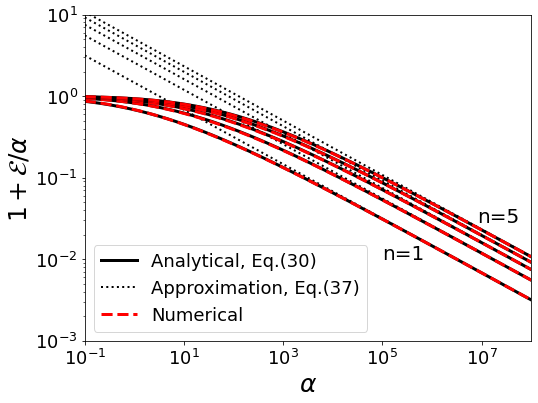

In [9]:
cmg = plt.get_cmap("Greens")
cmr = plt.get_cmap("Reds")
cmo = plt.get_cmap("Oranges")

plt.rcParams["font.size"] = 25
fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1,1,wspace=0.0,hspace=0.0)

ax = plt.subplot(gs[0,0])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1,1e8)
ax.set_ylim(1e-3,1e1)

for i in range(num_evals):
    if i==0:
        ax.plot(arr_alpha, 1+E1_ana1_list[i], lw=3, ls='-',  color="black", label="Analytical, Eq.(30) ")
        ax.plot(arr_alpha, 1+E1_ana2_list[i], lw=2, ls=':',  color="black", label="Approximation, Eq.(37)")
        ax.plot(arr_alpha, 1+E1_num_list[i], lw=3, ls='--',  color="red",   label="Numerical")
    else:
        ax.plot(arr_alpha, 1+E1_ana1_list[i], lw=3, ls='-',  color="black")
        ax.plot(arr_alpha, 1+E1_ana2_list[i], lw=2, ls=':',  color="black")
        ax.plot(arr_alpha, 1+E1_num_list[i], lw=3, ls='--',  color="red")

ax.set_xlabel("$\\alpha$",fontsize=25)
ax.set_ylabel("$1 + \\mathcal{E}/\\alpha$",fontsize=25)
ax.text(1e5,1e-2,"n=1",fontsize=20)
ax.text(8e6,2.8e-2,"n=5",fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc="lower left",fontsize=18)
#ax.grid()
ax.plot()

plt.show()

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/eigenvalues_n1-5.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

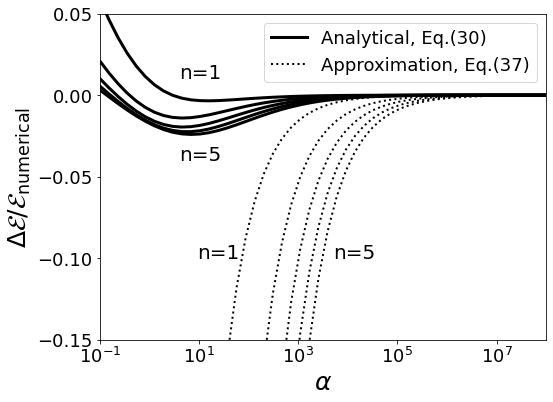

In [10]:
cmg = plt.get_cmap("Greens")
cmr = plt.get_cmap("Reds")
cmo = plt.get_cmap("Oranges")

plt.rcParams["font.size"] = 30
fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1,1,wspace=0.0,hspace=0.0)


ymin=-0.15
ymax= 0.05001 

ax = plt.subplot(gs[0,0])
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlim(1e-1,1e8)
ax.set_ylim(ymin, ymax)

for i in range(num_evals):
    if i==0:
        ax.plot(arr_alpha, E1_ana1_list[i]/E1_num_list[i]-1, lw=3, ls='-',  color="black", label="Analytical, Eq.(30)")
        ax.plot(arr_alpha, E1_ana2_list[i]/E1_num_list[i]-1, lw=2, ls=':',  color="black", label="Approximation, Eq.(37)")
    else:
        ax.plot(arr_alpha, E1_ana1_list[i]/E1_num_list[i]-1, lw=3, ls='-',  color="black")
        ax.plot(arr_alpha, E1_ana2_list[i]/E1_num_list[i]-1, lw=2, ls=':',  color="black")

ax.set_xlabel("$\\alpha$",fontsize=25)
ax.set_ylabel("$\\Delta\\mathcal{E}/\\mathcal{E}_{\\rm numerical}$",fontsize=25)
ax.text(4e0, ymin + 0.8*(ymax-ymin),"n=1",fontsize=20)
ax.text(4e0, ymin + 0.55*(ymax-ymin),"n=5",fontsize=20)
ax.text(9e0, ymin + 0.25*(ymax-ymin),"n=1",fontsize=20)
ax.text(5e3, ymin + 0.25*(ymax-ymin),"n=5",fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_yticks([-0.15,-0.1,-0.05,0,0.05])
ax.set_yticks(np.arange(ymin,ymax,0.05))
ax.legend(loc="upper right",fontsize=18)
#ax.grid()
ax.plot()

plt.show()

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/errors_eigenvalues_n1-5.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

## <font color="Red">Get soliton core-halo mass-concentration relations</font>

### Set cosmological parameters

In [11]:
##### Mass of FDM #####

mphi = 8.e-23

##### Redshift #####

zred = 0

##### Cosmological parameters #####

hubble = 0.677
Omegam0 = 0.276
Omegab0 = 0.02258/hubble**2
OmegaCDM0 = Omegam0 - Omegab0
OmegaL0 = 1-Omegam0
sigma_8 = 0.8

rho_crit0 = 2.77536627e11
rho_m0 = Omegam0*rho_crit0 # in unit h^{2} Msun/Mpc^{3}

### Load simulation data

In [12]:
####### Data from Chan et al. ('22)

sim_soliton = np.loadtxt("../data_sim/Soliton_Merger.dat")
sim_cosmo = np.loadtxt("../data_sim/Cosmo_Simulation.dat")

### Definitions

In [13]:
###############################
#####       Alpha        ######
###############################

def alpha(z, m_FDM, mass, cvir):
    result = 7.213e4 * (m_FDM/1e-21)**2 * (mass/1e9)**(4.0/3.0) * (Deltavir(z)/200)**(-1.0/3.0) * (Omegam0*hubble**2/0.147)**(-1.0/3.0) * fcvir(cvir)/(1+z)
    return result

vect_alpha = np.vectorize(alpha)


#############################################
#####  Cosmology dependent functions   ######
#############################################

#### (Redshift dependent) matter density parameter ####

def Omegam(z):
    return (1+z)**3 * Omegam0/((1+z)**3 * Omegam0 + OmegaL0)

#### Virial overdensity ####

def Deltavir(z):
    result = 18*np.pi**2 + 82*(Omegam(z)-1)-39*(Omegam(z)-1)**2
    result = result/Omegam(z)
    return result

###############################################
#####  Functions for halo concentration  ######
###############################################

def gcvir(cvir):
    return (np.log(1+cvir)-cvir/(1+cvir))/cvir

def fcvir(cvir):
    return 1/(cvir*(np.log(1+cvir)-cvir/(1+cvir)))

#################################
##### Soliton core radius #######
#################################

def xc_ana(alpha):    ### core radius normalized by r_s
#    En_alpha = func_Enalpha(np.log(alpha))
    En_alpha = get_E0(alpha,-0.999)
    beta = alpha * (1+En_alpha) /6
    return 0.65*(1/beta)**0.5

vect_xc_ana = np.vectorize(xc_ana)

def rc(z, m_FDM, mass, cvir, alpha0):    ### !!!!  This is physical radius !!!!
    En_alpha = func_Enalpha(np.log(alpha0))
    result = 0.1147 * (1+z)**(-0.5) * (m_FDM/1e-21)**(-1) * (mass/1e9)**(-1.0/3.0) * (Deltavir(z)/200)**(-1.0/6.0) * (Omegam0*hubble**2/0.147)**(-1.0/6.0) * (6/(1+En_alpha))**0.5 * gcvir(cvir)**0.5
    result = result * 0.65
    return result

vect_rc = np.vectorize(rc)

def rc_ana(z, m_FDM, mass, cvir):    ### !!!!  This is physical radius !!!!
    En_alpha = get_E0(alpha(z, m_FDM, mass, cvir),-0.999)
    result = 0.1147 * (1+z)**(-0.5) * (m_FDM/1e-21)**(-1) * (mass/1e9)**(-1.0/3.0) * (Deltavir(z)/200)**(-1.0/6.0) * (Omegam0*hubble**2/0.147)**(-1.0/6.0) * (6/(1+En_alpha))**0.5 * gcvir(cvir)**0.5
    result = result * 0.65
    return result

vect_rc_ana = np.vectorize(rc_ana)

def r_core_limit(z, m_FDM, mass):  # theoretical upper bound
    result = 3.59161 * (1+z)**(-2./3.) * (m_FDM/1e-22)**(-2./3.) * (mass/1e9)**(-1.0/9.0) * (Deltavir(z)/200)**(-2.0/9.0) * (Omegam0*hubble**2/0.147)**(-2.0/9.0)
    return result

vect_r_core_limit = np.vectorize(r_core_limit)


###############################
##### Soliton core mass #######
###############################

def Mc(z, m_FDM, mass, cvir, alpha0):
    En_alpha = func_Enalpha(np.log(alpha0))
    r_star   = 0.1147 * (1+z)**(-0.5) * (m_FDM/1e-21)**(-1) * (mass/1e9)**(-1.0/3.0) * (Deltavir(z)/200)**(-1.0/6.0) * (Omegam0*hubble**2/0.147)**(-1.0/6.0) * (6/(1+En_alpha))**0.5 * gcvir(cvir)**0.5
    # rc       = 0.60169 * r_star                         # in units of kpc
    rc       = 0.65 * r_star                         # in units of kpc
    rhoc     = 1.9*(1+z)*(m_FDM/1e-23)**(-2)*rc**(-4) # in units of M_sun / kpc**3
    result   = 4*(np.pi)*0.2225*rhoc*rc**3 *1e9         # in units of M_sun
    return result

vect_Mc = np.vectorize(Mc)

def Mc_ana(z, m_FDM, mass, cvir):
    En_alpha = get_E0(alpha(z, m_FDM, mass, cvir),-0.999)
    r_star   = 0.1147 * (1+z)**(-0.5) * (m_FDM/1e-21)**(-1) * (mass/1e9)**(-1.0/3.0) * (Deltavir(z)/200)**(-1.0/6.0) * (Omegam0*hubble**2/0.147)**(-1.0/6.0) * (6/(1+En_alpha))**0.5 * gcvir(cvir)**0.5
    # rc       = 0.60169 * r_star                     # in units of kpc
    rc       = 0.65 * r_star                          # in units of kpc
    rhoc     = 1.9*(1+z)*(m_FDM/1e-23)**(-2)*rc**(-4) # in units of M_sun / kpc**3
    result   = 4*(np.pi)*0.2225*rhoc*rc**3 *1e9       # in units of M_sun
    return result

vect_Mc_ana = np.vectorize(Mc_ana)

def M_core_limit(z, m_FDM, mass):  # theoretical lower bound
    result = 1.47912e7 * (1+z)**(2./3.) * (m_FDM/1e-22)**(2./3.) * (mass/1e9)**(1.0/9.0) * (Deltavir(z)/200)**(2.0/9.0) * (Omegam0*hubble**2/0.147)**(2.0/9.0)
    return result

vect_M_core_limit = np.vectorize(M_core_limit)


### Figure 5: core-halo mass-concentration relations

/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/3689203394.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)
/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/3689203394.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)


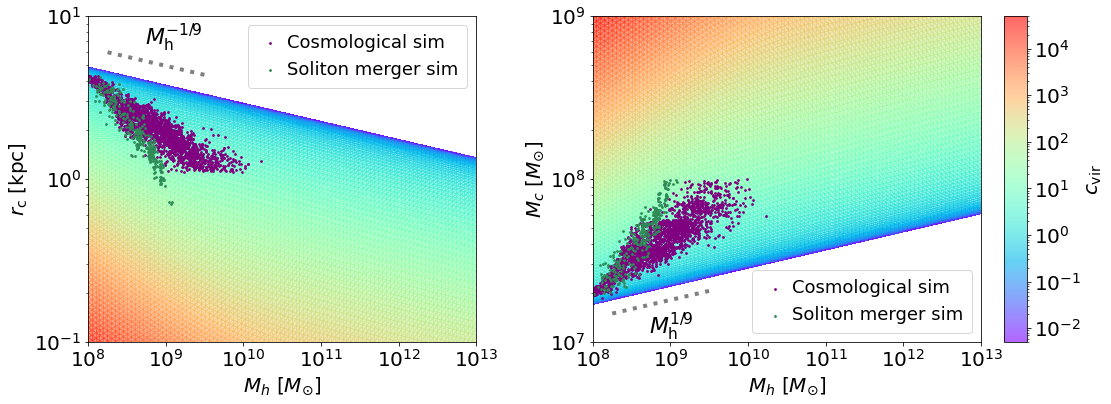

In [15]:
vmin = 5.e-3
vmax = 5.e4

result_rc_x = np.array([])
result_rc_y = np.array([])
result_rc_z = np.array([])

result_Mc_x = np.array([])
result_Mc_y = np.array([])
result_Mc_z = np.array([])

N_rand=100
rand_Mvir = np.logspace(8,13,N_rand)
rand_cvir = np.logspace(np.log10(vmin),np.log10(vmax),N_rand)
for i in range(len(rand_Mvir)):
    Mvir_here = rand_Mvir[i]
    for j in range(len(rand_cvir)):
        cvir_here = rand_cvir[j]
        alpha_here = vect_alpha(zred,mphi,Mvir_here,cvir_here)
        result_rc_x = np.append(result_rc_x, Mvir_here)
        result_rc_y = np.append(result_rc_y, vect_rc(zred,mphi,Mvir_here,cvir_here,alpha_here))
        result_rc_z = np.append(result_rc_z, cvir_here)
        result_Mc_x = np.append(result_Mc_x, Mvir_here)
        result_Mc_y = np.append(result_Mc_y, vect_Mc(zred,mphi,Mvir_here,cvir_here,alpha_here))
        result_Mc_z = np.append(result_Mc_z, cvir_here)

theory_color1 = "blue"
cmap = "rainbow"
fig = plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

##########################################
##### core radius-halo mass relation #####
##########################################

ax = fig.add_subplot(1,2,1)

ax.set_xlim(8,13)
ax.set_yscale("log")
#ax.set_ylim(0.2,10)
ax.set_ylim(0.1,10)
ax.tripcolor(np.log10(result_rc_x), result_rc_y, result_rc_z, cmap=cmap, alpha=0.6,norm = LogNorm())

# ax.scatter(np.log10(sim_cosmo[:,0]),sim_cosmo[:,2],s=3, color="purple", label="May & Springel ('21)")
# ax.scatter(np.log10(sim_soliton[:,0]),sim_soliton[:,2],s=3, color="seagreen", label="Chan et al. ('22)")
ax.scatter(np.log10(sim_cosmo[:,0]),sim_cosmo[:,2],s=3, color="purple", label="Cosmological sim")
ax.scatter(np.log10(sim_soliton[:,0]),sim_soliton[:,2],s=3, color="seagreen", label="Soliton merger sim")

### halo mass dependence of the critical core size 
Mvir_min = np.min(rand_Mvir)
Mvir_max = np.max(rand_Mvir)
xmin1 = 10**( np.log10(Mvir_min) + 0.05* (np.log10(Mvir_max) - np.log10(Mvir_min)) )
xmax1 = 10**( np.log10(Mvir_min) + 0.3* (np.log10(Mvir_max) - np.log10(Mvir_min)) )
slope = - 1./9.
yfid  = 6.
yy    = np.logspace(np.log10(xmin1), np.log10(xmax1), 30)
rcrit_power =  yfid * (yy/xmin1) ** slope
ax.plot(np.log10(yy), rcrit_power, ":", lw=4, color='gray')
ax.text(np.log10(3*xmin1), 1.1*yfid, "$M_{\\rm h}^{-1/9}$",fontsize=22)

ax.set_xlabel("$M_h$ [$M_{\\odot}$]",fontsize=20)
ax.set_ylabel(r"$r_{\rm c}$ [kpc]",fontsize=20)
ax.legend(loc="upper right",borderpad=0.5, handlelength=1.5, handletextpad=0.2, fontsize=18)

name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)


##########################################
##### core mass-halo mass relation #######
##########################################

ax = fig.add_subplot(1,2,2)

ax.set_xlim(8,13)
#ax.set_ylim(7,np.log10(2e8))
ax.set_ylim(7, 9)
ax.tripcolor(np.log10(result_Mc_x), np.log10(result_Mc_y), result_Mc_z, cmap=cmap, alpha=0.6,norm = LogNorm())

# ax.scatter(np.log10(sim_cosmo[:,0]),np.log10(sim_cosmo[:,1]),s=3, color="purple", label="May & Springel ('21)")
# ax.scatter(np.log10(sim_soliton[:,0]),np.log10(sim_soliton[:,1]),s=3, color="seagreen", label="Chan et al. ('22)")
ax.scatter(np.log10(sim_cosmo[:,0]),np.log10(sim_cosmo[:,1]),s=3, color="purple", label="Cosmological sim")
ax.scatter(np.log10(sim_soliton[:,0]),np.log10(sim_soliton[:,1]),s=3, color="seagreen", label="Soliton merger sim")

### halo mass dependence of the critical core mass 
Mvir_min = np.min(rand_Mvir)
Mvir_max = np.max(rand_Mvir)
xmin1 = 10**( np.log10(Mvir_min) + 0.05* (np.log10(Mvir_max) - np.log10(Mvir_min)) )
xmax1 = 10**( np.log10(Mvir_min) + 0.3* (np.log10(Mvir_max) - np.log10(Mvir_min)) )
slope = 1./9.
yfid  = 1.5e7
yy    = np.logspace(np.log10(xmin1), np.log10(xmax1), 30)
Mcrit_power =  yfid * (yy/xmin1) ** slope
ax.plot(np.log10(yy), np.log10(Mcrit_power), ":", lw=4, color='gray')
ax.text(np.log10(3*xmin1), np.log10(0.75*yfid), "$M_{\\rm h}^{1/9}$",fontsize=22)

ax.set_xlabel("$M_h$ $[M_{\\odot}]$",fontsize=20)
ax.set_ylabel("$M_c$ $[M_{\\odot}]$",fontsize=20)
ax.legend(loc="lower right",borderpad=0.5, handlelength=1.5, handletextpad=0.2, fontsize=18)

name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.yaxis.set_ticks([7,8,9])
ax.set_yticklabels(["$10^{7}$","$10^{8}$","$10^{9}$"])
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)
ax.yaxis.set_minor_locator(FixedLocator(np.log10([1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8])))


axpos_here = ax.get_position()
cbar_ax = fig.add_axes([axpos_here.x0+axpos_here.width+0.02, axpos_here.y0, 0.02, axpos_here.y0-axpos_here.y0+axpos_here.height])
norm = LogNorm(vmin=vmin, vmax=vmax)
mappable = ScalarMappable(cmap=cmap,norm=norm)
cb = plt.colorbar(mappable, cax=cbar_ax, alpha=0.6)
cb.ax.tick_params(labelsize=25)
cb.set_label("$c_{\\rm vir}$",fontsize=20)
cb.ax.tick_params(labelsize=20)


#plt.savefig("Mc_Mvir.pdf", bbox_inches="tight", pad_inches=0.1, transparent=True)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/core_halo_mass_concentration.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

## <font color="Red">Get predictions for core-halo relations of FDM & CDM models</font>

### Get core-halo relations in Schive et al. ('14)

In [16]:
def Mc_Schive_etal(z, m_FDM, mass):   # in units of M_sun
    rhom0 = 8.0992e-11 * Omegam0 * hubble**2   # present matter density in units of eV**4 
    H0 = (2.1332e-33) * hubble                 # Hubble parameter       in units of eV
    eV2Msun = 1 / 1.116e66                     # convert eV to M_sun
    Mmin0 = 32*(np.pi) * (Deltavir(0)/375)**(1/4) * rhom0 * (H0*m_FDM)**(-3/2) * Omegam0**(-3/4) * eV2Msun
    # Mmin0 = 4.4e7 * (mphi/1e-22)**(-3/2)        
    return 0.25 * (1+z)**(1/2) * (Deltavir(z)/Deltavir(0))**(1/6) * (mass/Mmin0)**(1/3) * Mmin0

def rc_Schive_etal(z, m_FDM, mass):    # in units of kpc
    rhoc_kpc = 1.9e9 * (1+z) * (m_FDM/1e-23)**(-2)  # in units of M_sun / kpc
    return 4*(np.pi) * 0.2225 * rhoc_kpc / Mc_Schive_etal(z, m_FDM, mass)


vect_Mc_Schive_etal = np.vectorize(Mc_Schive_etal)
vect_rc_Schive_etal = np.vectorize(rc_Schive_etal)


### Get linear power spectrum

In [17]:
from classy import Class

In [18]:
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'Omega_b':Omegab0,'Omega_cdm':OmegaCDM0,'h':hubble, 'sigma8': sigma_8})
LambdaCDM.set({'output':'tCl,mPk','P_k_max_1/Mpc':5000.0})
# run class
LambdaCDM.compute()

# get P(k) at redhsift z=0
kk = np.logspace(-4,3,5000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
sigma8 = LambdaCDM.sigma8()
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

Pk_int=interp1d(kk, Pk)   #  power spectrum is in units of (Mpc/h)^3 and wavenumber is in units of h/Mpc

In [20]:
### Transfer function for FDM model (Hu, Barkana & Gruzinov '20)

def Transfer_FDM(k,mphi):   # k is in units of h/Mpc
    k_Jeq = 9 * (mphi/1e-22)**0.5/hubble
    xJ = 1.61 * (mphi/1e-22)**(1/18.0) * k/k_Jeq
    return np.cos(xJ**3)/(1+xJ**8)

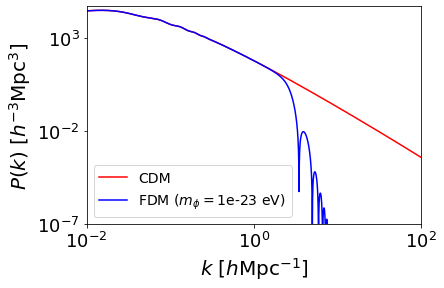

In [21]:
mm= 1.e-23  # FDM mass (in units of eV)

Pk_FDM_test = np.array([])
for i in range(len(kk)):
    Pk_FDM_test = np.append(Pk_FDM_test,Pk[i]*Transfer_FDM(kk[i],mm)**2)

plt.figure(figsize=(6, 4))
#plt.figure(1)
plt.xscale('log');
plt.yscale('log');
plt.plot(kk,Pk, "red",label="CDM")
plt.plot(kk,Pk_FDM_test, "blue", label="FDM ($m_\\phi=$%2.1g eV)"%mm)
plt.xlabel("$k$ [$h{\\rm Mpc}^{-1}$]",fontsize=20)
plt.ylabel("$P(k)$ [$h^{-3}{\\rm Mpc}^3$]",fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(1e-2,1e2)
plt.ylim(1e-7,5e4)
plt.legend(fontsize=14)
plt.show()

### Definitions

In [22]:
#### Linear growth factor ####

def Dgrowth(z):
    bunsi = scp.hyp2f1(1/3, 1, 11/6, -OmegaL0/Omegam0*(1+z)**(-3))
    bunbo = scp.hyp2f1(1/3, 1, 11/6, -OmegaL0/Omegam0)
    result = bunsi/bunbo/(1+z)
    return result

#### Critical density contrast (Mead et al. )####

def delta_crit(z):
    return 1.59 + 0.0314*np.log(sigma8*Dgrowth(z))

#### Top-hat window function ####

def Window(k, mass):  # k is in units of h/Mpc, M is supposed to be in units of M_sun/h
    R = (mass/(4*np.pi/3*rho_m0))**(1/3.0)
    result = 3*scp.spherical_jn(1,k*R)/(k*R)
    return result


### Get mass variance $\sigma(M)$

#### CDM model

In [23]:
def integrand_CDM(k, mass):
    return k**2 * Window(k, mass)**2 * Pk_int(k)/(2*np.pi**2)

def sigma_M_CDM(mass):
    result = quad(integrand_CDM, min(kk), max(kk), args=(mass))
    return np.sqrt(result[0])

# Interpolation
Mass_tmp = np.logspace(0.0, 15.0, num=100)
sigma_M_CDM_arr = np.array([])
for i in range(len(Mass_tmp)):
    sigma_M_CDM_arr = np.append(sigma_M_CDM_arr,sigma_M_CDM(Mass_tmp[i]))
    
sigma_M_CDM_int=interp1d(Mass_tmp, sigma_M_CDM_arr)

/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/3987134259.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = quad(integrand_CDM, min(kk), max(kk), args=(mass))
/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/3987134259.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = quad(integrand_CDM, min(kk), max(kk), args=(mass))


In [24]:
sigma_M_CDM_arr

array([9.42591513, 9.42549937, 9.42497497, 9.42431361, 9.42347964,
       9.42242821, 9.42110292, 9.41943292, 9.4173293 , 9.4146807 ,
       9.41134786, 9.40715705, 9.40189226, 9.39528586, 9.38700805,
       9.37665494, 9.36373598, 9.34766176, 9.32773396, 9.30314041,
       9.27295978, 9.23618204, 9.19175243, 9.13864794, 9.07598868,
       9.00318597, 8.9201005 , 8.82716483, 8.72538983, 8.61617752,
       8.50092087, 8.3805461 , 8.25532666, 8.12523711, 7.99058677,
       7.85215171, 7.71062059, 7.56641431, 7.4200991 , 7.27219403,
       7.12310824, 6.97324906, 6.82294383, 6.67247965, 6.52210146,
       6.37201324, 6.22238781, 6.07336981, 5.92508192, 5.77762656,
       5.63109261, 5.48555534, 5.34108076, 5.19772716, 5.05554636,
       4.91458667, 4.77489204, 4.63650264, 4.49945915, 4.36379893,
       4.22955907, 4.09677544, 3.96548475, 3.835723  , 3.70752716,
       3.58093275, 3.45597805, 3.33270039, 3.21113774, 3.09132942,
       2.97331404, 2.85713093, 2.74282254, 2.63042889, 2.51999

#### FDM model

In [25]:
def integrand_FDM(k, mass, m_FDM):
    return k**2 * Window(k, mass)**2 * Pk_int(k) * Transfer_FDM(k,m_FDM)**2/(2*np.pi**2)

def sigma_M_FDM(mass, m_FDM):
    result = quad(integrand_FDM, min(kk), max(kk), args=(mass, m_FDM))
    return np.sqrt(result[0])

# mphi = 8.e-23
Mass_tmp = np.logspace(0.0, 15.0, num=100)
sigma_M_FDM_arr = np.array([])
for i in range(len(Mass_tmp)):
    sigma_M_FDM_arr = np.append(sigma_M_FDM_arr,  sigma_M_FDM(Mass_tmp[i], mphi))
    
sigma_M_FDM_int=interp1d(Mass_tmp, sigma_M_FDM_arr)

/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/2678358914.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = quad(integrand_FDM, min(kk), max(kk), args=(mass, m_FDM))
/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/2678358914.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = quad(integrand_FDM, min(kk), max(kk), args=(mass, m_FDM))


In [26]:
sigma_M_FDM_arr

array([3.54301982, 3.5430198 , 3.54301977, 3.54301974, 3.5430197 ,
       3.54301965, 3.54301959, 3.54301951, 3.54301942, 3.54301929,
       3.54301914, 3.54301894, 3.54301869, 3.54301837, 3.54301798,
       3.54301748, 3.54301684, 3.54301605, 3.54301504, 3.54301377,
       3.54301217, 3.54301015, 3.5430076 , 3.54300438, 3.54300031,
       3.54299519, 3.54298872, 3.54298056, 3.54297026, 3.54295726,
       3.54294087, 3.54292017, 3.54289406, 3.54286112, 3.54281955,
       3.54276709, 3.5427009 , 3.54261739, 3.54251202, 3.54237907,
       3.54221132, 3.54199969, 3.5417327 , 3.54139589, 3.54097104,
       3.54043516, 3.53975933, 3.53890713, 3.53783272, 3.53647847,
       3.53477199, 3.53262245, 3.52991607, 3.52651058, 3.52222854,
       3.51684929, 3.51009957, 3.50164266, 3.49106629, 3.47787008,
       3.46145313, 3.44110429, 3.41599788, 3.38519979, 3.34769156,
       3.3024198 , 3.24838288, 3.18476257, 3.11110137, 3.02750853,
       2.9348462 , 2.8348013 , 2.72973881, 2.62225333, 2.51453

### Get concentration-mass relations

#### Bullock et al. ('01)

In [27]:
fcoll = 0.01

## Caution !!  mass is in units of M_sun/h

def func_CDM(zcoll,z, mass):
    return Dgrowth(zcoll)/Dgrowth(z)*sigma_M_CDM_int(fcoll*mass) - delta_crit(z)

def c_Bullock_CDM(mass,z):
    coef_A = 3.13
    result = coef_A * (1+fsolve(func_CDM, 0.1, args=(z, mass)))/(1+z)
    return result

vect_c_Bullock_CDM = np.vectorize(c_Bullock_CDM)

#### Dentler et al. ('21)

In [28]:
fcoll = 0.01

## Caution !!  mass is in units of M_sun/h

def func_FDM(zcoll, z, mass):    # !! Caution !!    sigma_M_FDM_init implicitly depends on FDM mass (see the function defined above)
    return Dgrowth(zcoll)/Dgrowth(z)*sigma_M_FDM_int(fcoll*mass) - delta_crit(z)

def c_Bullock_FDM(mass, z):
    coef_A = 3.13
    result = coef_A * (1+fsolve(func_FDM, 0.1, args=(z, mass)))/(1+z)
    return result

# def Delta_FDM_c(Mass,mphi):
#     gamma1 = 15
#     gamma2 = 0.3
#     M0n = (1.6e10*(mphi/1e-22)**(4/3.0)) * hubble   #### in units of M_sun/h 
#     M0c = M0n / fcoll                                #### in units of M_sun/h
#     deltaM0 = M0c * 1e-3
#     gamma0 = M0c*(c_Bullock_FDM(M0c+deltaM0,zred)-c_Bullock_FDM(M0c-deltaM0,zred))/(2*deltaM0)
#     result = (1 + Mass/M0c)**(gamma0) * (1 + gamma1 * (M0c/Mass))**(-gamma2) 
#     return result


# def c_Dentler(mass,zred,mphi):    
#     result = c_Bullock_FDM(mass,zred) * Delta_FDM_c(mass,mphi)
#     return result

def Delta_Schneider(mass, m_FDM):
    gamma1 = 15
    gamma2 = 0.3
    M0n = (1.6e10*(m_FDM/1e-22)**(-4/3.0)) * hubble   #### in units of M_sun/h                                #### in units of M_sun/h
    result =  (1 + gamma1 * (M0n/mass))**(-gamma2) 
    return result

def c_Schneider(mass, z, m_FDM):    
    result = c_Bullock_CDM(mass,z) * Delta_Schneider(mass,m_FDM)
    return result

def Delta_Extrapol(mass, z, m_FDM):
    gamma1 = 15
    gamma2 = 0.3
    M0n = (1.6e10*(m_FDM/1e-22)**(-4/3.0)) * hubble   #### in units of M_sun/h 
    M0c = M0n / fcoll                               #### in units of M_sun/h
    M0400 = M0n * 400.                                #### in units of M_sun/h
    deltaM0 = M0400 * 1e-3 #calculate the derivative a bit before the scaling parameter, where no turnover has happend yet
    gamma0 = M0400/c_Bullock_FDM(M0400, z)*(c_Bullock_FDM(M0400+deltaM0, z)-c_Bullock_FDM(M0400-deltaM0, z))/(2*deltaM0)
    result =  (1 + M0c/mass)**(-gamma0) ##apply the extrapolation at around where the suppression starts. THis is correct
    return result

def c_Extrapol(mass, z, m_FDM):    
    result = c_Bullock_FDM(mass, z) * Delta_Extrapol(mass, z, m_FDM)
    return result

def c_Dentler(mass, z, m_FDM):    
    result = c_Bullock_FDM(mass, z) * Delta_Extrapol(mass, z, m_FDM) * Delta_Schneider(mass, m_FDM)
    return result

vect_c_Dentler = np.vectorize(c_Dentler)

#### Comparison: Fig. 7

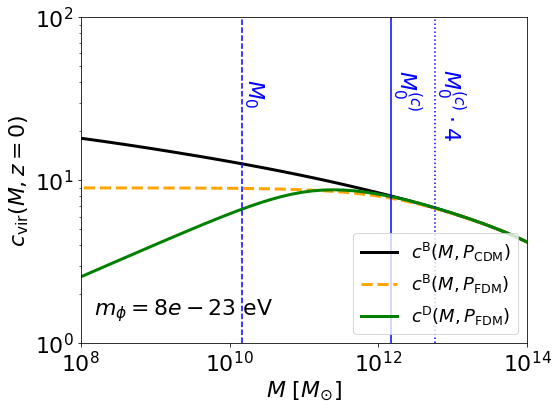

In [29]:
sigma8=sigma_8
zred = 0.0
mphi = 8.e-23

M0n = (1.6e10*(mphi/1e-22)**(-4/3.0)) * hubble
M0c = M0n / fcoll
M0400 = M0n * 400.

Mass_tmp = np.logspace(8, 15.0, num=50)
c_Bullock_CDM_arr = np.array([])
c_Bullock_FDM_arr = np.array([])
c_Dentler_arr = np.array([])
for i in range(len(Mass_tmp)):
    c_Bullock_CDM_arr = np.append(c_Bullock_CDM_arr,c_Bullock_CDM(Mass_tmp[i],zred))
    c_Bullock_FDM_arr = np.append(c_Bullock_FDM_arr,c_Bullock_FDM(Mass_tmp[i],zred))
    c_Dentler_arr = np.append(c_Dentler_arr, c_Dentler(Mass_tmp[i],zred,mphi))
    
plt.figure(figsize=(8, 6))
plt.rcParams["font.size"] = 22
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e8,1e14)
plt.ylim(1,100)
plt.xlabel("$M$ [$M_{\\odot}$]",fontsize=22)
plt.ylabel("$c_{\\rm vir}(M,z=%2.1g)$"%zred,fontsize=22)
plt.plot(hubble*Mass_tmp,c_Bullock_CDM_arr,"black", lw=3, label="$c^{\\rm B}(M, P_{\\rm CDM})$")
plt.plot(hubble*Mass_tmp,c_Bullock_FDM_arr,"orange", ls='--', lw=3, label="$c^{\\rm B}(M,P_{\\rm FDM})$")
plt.plot(hubble*Mass_tmp,c_Dentler_arr,"green", lw=3,label="$c^{\\rm D}(M,P_{\\rm FDM})$")
plt.text(1.5e8, 1.5, "$m_\\phi=%2.2g$ eV"%mphi, fontsize=22)
plt.axvline(x=M0n,c="blue",ls='--')
plt.text(M0n, 30, "$M_0$", fontsize=22,c="blue",rotation=-90)
plt.axvline(x=M0c,c="blue")
plt.text(M0c, 30, "$M^{(c)}_0$", fontsize=22,c="blue",rotation=-90)
plt.axvline(x=M0400,c="blue",ls=':')
plt.text(M0400, 20, "$M^{(c)}_0\cdot 4$", fontsize=22,c="blue",rotation=-90)

plt.legend(loc="lower right",fontsize=18)
plt.show()

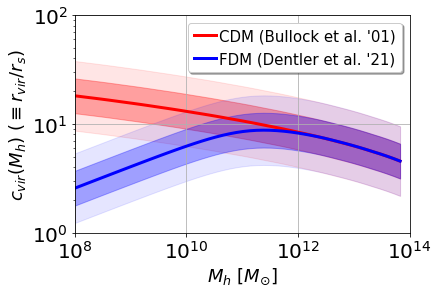

In [30]:
zz = zred
mm = mphi

Mass_tmp = np.logspace(8.0, 14.0, num=50)
c_Bullock_CDM_arr = np.array([])
c_Dentler_arr = np.array([])
for i in range(len(Mass_tmp)):
    c_Bullock_CDM_arr = np.append(c_Bullock_CDM_arr,c_Bullock_CDM(Mass_tmp[i],zz))
    c_Dentler_arr = np.append(c_Dentler_arr, c_Dentler(Mass_tmp[i], zz, mm))

plt.rcParams["font.size"] = 20
fig=plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(1,1,wspace=0.0,hspace=0.0)
ax = plt.subplot(gs[0,0])
ax.set_xscale('log');
ax.set_yscale('log');
ax.plot(hubble*Mass_tmp,c_Bullock_CDM_arr,"red", lw=3, label="CDM (Bullock et al. '01)")
ax.fill_between(hubble*Mass_tmp, 10**(np.log10(c_Bullock_CDM_arr)+0.32), 10**(np.log10(c_Bullock_CDM_arr)-0.32), color="red", alpha=0.1)
ax.fill_between(hubble*Mass_tmp, 10**(np.log10(c_Bullock_CDM_arr)+0.16), 10**(np.log10(c_Bullock_CDM_arr)-0.16), color="red", alpha=0.3)

ax.plot(hubble*Mass_tmp,c_Dentler_arr,   "blue", lw=3, label="FDM (Dentler et al. '21)")
ax.fill_between(hubble*Mass_tmp, 10**(np.log10(c_Dentler_arr)+0.32), 10**(np.log10(c_Dentler_arr)-0.32), color="blue", alpha=0.1)
ax.fill_between(hubble*Mass_tmp, 10**(np.log10(c_Dentler_arr)+0.16), 10**(np.log10(c_Dentler_arr)-0.16), color="blue", alpha=0.3)
ax.set_xlabel("$M_{h}$ [$M_{\\odot}$]",fontsize=18)
ax.set_ylabel("$c_{vir}(M_{h})\,\,(\\equiv r_{vir}/r_s)$",fontsize=18)
ax.grid()
ax.set_xlim(1e8, 1e14)
ax.set_ylim(1., 100)
ax.legend(shadow=True,loc='upper right',fontsize=15,handletextpad=0.2,handlelength= 1.5, borderaxespad=0.5)

plt.show()
## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/cM_relation.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

### Results:  Figs. 8 & 9 

In [31]:
arr_Mvir = np.logspace(8.0, 13.0, num=10)

arr_cvir_CDM  = vect_c_Bullock_CDM(hubble*arr_Mvir, zred)
arr_alpha_CDM = vect_alpha(zred, mphi, arr_Mvir, arr_cvir_CDM)

arr_cvir_FDM  = vect_c_Dentler(hubble*arr_Mvir, zred, mphi)
arr_alpha_FDM = vect_alpha(zred, mphi, arr_Mvir, arr_cvir_FDM)

arr_rc_CDM = vect_rc(zred, mphi, arr_Mvir, arr_cvir_CDM, arr_alpha_CDM)
arr_rc_FDM = vect_rc(zred, mphi, arr_Mvir, arr_cvir_FDM, arr_alpha_FDM)

arr_rc_CDM_ana = vect_rc_ana(zred, mphi, arr_Mvir, arr_cvir_CDM)
arr_rc_FDM_ana = vect_rc_ana(zred, mphi, arr_Mvir, arr_cvir_FDM)

arr_Mc_CDM = vect_Mc(zred, mphi, arr_Mvir, arr_cvir_CDM, arr_alpha_CDM)
arr_Mc_FDM = vect_Mc(zred, mphi, arr_Mvir, arr_cvir_FDM, arr_alpha_FDM)

arr_Mc_CDM_ana = vect_Mc_ana(zred, mphi, arr_Mvir, arr_cvir_CDM)
arr_Mc_FDM_ana = vect_Mc_ana(zred, mphi, arr_Mvir, arr_cvir_FDM)


In [32]:
# confidencial interval
ci1 = 0.6827
ci2 = 0.9545

# 0.16 dex
sigma = 0.16 

result_rc_CDM_using_mean_cvir = np.array([])
result_rc_CDM_median = np.array([])
result_rc_CDM_1sigma_1 = np.array([])
result_rc_CDM_1sigma_2 = np.array([])
result_rc_CDM_2sigma_1 = np.array([])
result_rc_CDM_2sigma_2 = np.array([])

result_rc_FDM_using_mean_cvir = np.array([])
result_rc_FDM_median = np.array([])
result_rc_FDM_1sigma_1 = np.array([])
result_rc_FDM_1sigma_2 = np.array([])
result_rc_FDM_2sigma_1 = np.array([])
result_rc_FDM_2sigma_2 = np.array([])

start = time.time()
for i in range(len(arr_Mvir)):
#     mu = np.log(arr_cvir_CDM[i]) - 0.5*sigma**2
#     cvir_prob = np.random.lognormal(mu, sigma, 100000)
    mu = np.log10(arr_cvir_CDM[i])
    log10cvir_prob = np.random.normal(mu, sigma, 100000)
    cvir_prob = 10**log10cvir_prob
    result_rc_CDM_using_mean_cvir = np.append(result_rc_CDM_using_mean_cvir, vect_rc(zred,mphi,arr_Mvir[i],arr_cvir_CDM[i],alpha(zred,mphi,arr_Mvir[i],arr_cvir_CDM[i])))
    alpha_prob = vect_alpha(zred,mphi,arr_Mvir[i],cvir_prob)
    test_CDM_s = vect_rc(zred,mphi,arr_Mvir[i],cvir_prob,alpha_prob)
    result_rc_CDM_median = np.append(result_rc_CDM_median, np.median(test_CDM_s))
    tmp_CDM = st.mstats.mquantiles(test_CDM_s,[0.5*(1-ci1),0.5*(1+ci1)])
    result_rc_CDM_1sigma_1 = np.append(result_rc_CDM_1sigma_1, tmp_CDM[0])
    result_rc_CDM_1sigma_2 = np.append(result_rc_CDM_1sigma_2, tmp_CDM[1])
    tmp_CDM = st.mstats.mquantiles(test_CDM_s,[0.5*(1-ci2),0.5*(1+ci2)])
    result_rc_CDM_2sigma_1 = np.append(result_rc_CDM_2sigma_1, tmp_CDM[0])
    result_rc_CDM_2sigma_2 = np.append(result_rc_CDM_2sigma_2, tmp_CDM[1])

#     mu = np.log(arr_cvir_FDM[i]) - 0.5*sigma**2
#     cvir_prob = np.random.lognormal(mu, sigma, 100000)
    mu = np.log10(arr_cvir_FDM[i])
    log10cvir_prob = np.random.normal(mu, sigma, 100000)
    cvir_prob = 10**log10cvir_prob
    result_rc_FDM_using_mean_cvir = np.append(result_rc_FDM_using_mean_cvir, vect_rc(zred,mphi,arr_Mvir[i],arr_cvir_FDM[i],alpha(zred,mphi,arr_Mvir[i],arr_cvir_FDM[i])))
    alpha_prob = vect_alpha(zred,mphi,arr_Mvir[i],cvir_prob)
    test_FDM_s = vect_rc(zred,mphi,arr_Mvir[i],cvir_prob,alpha_prob)
    result_rc_FDM_median = np.append(result_rc_FDM_median, np.median(test_FDM_s))
    tmp_FDM = st.mstats.mquantiles(test_FDM_s,[0.5*(1-ci1),0.5*(1+ci1)])
    result_rc_FDM_1sigma_1 = np.append(result_rc_FDM_1sigma_1, tmp_FDM[0])
    result_rc_FDM_1sigma_2 = np.append(result_rc_FDM_1sigma_2, tmp_FDM[1])
    tmp_FDM = st.mstats.mquantiles(test_FDM_s,[0.5*(1-ci2),0.5*(1+ci2)])
    result_rc_FDM_2sigma_1 = np.append(result_rc_FDM_2sigma_1, tmp_FDM[0])
    result_rc_FDM_2sigma_2 = np.append(result_rc_FDM_2sigma_2, tmp_FDM[1])
print("{:f}".format((time.time() - start)/60.0)+" min")

1.136133 min


In [33]:
# confidencial interval
ci1 = 0.6827
ci2 = 0.9545

# 0.16 dex
#sigma = 10**(0.16)
sigma = 0.16

result_Mc_CDM_median = np.array([])
result_Mc_CDM_using_mean_cvir = np.array([])
result_Mc_CDM_1sigma_1 = np.array([])
result_Mc_CDM_1sigma_2 = np.array([])
result_Mc_CDM_2sigma_1 = np.array([])
result_Mc_CDM_2sigma_2 = np.array([])

result_Mc_FDM_median = np.array([])
result_Mc_FDM_using_mean_cvir = np.array([])
result_Mc_FDM_1sigma_1 = np.array([])
result_Mc_FDM_1sigma_2 = np.array([])
result_Mc_FDM_2sigma_1 = np.array([])
result_Mc_FDM_2sigma_2 = np.array([])

start = time.time()
for i in range(len(arr_Mvir)):
#     mu = np.log(arr_cvir_CDM[i]) - 0.5*sigma**2
#     cvir_prob = np.random.lognormal(mu, sigma, 100000)
    mu = np.log10(arr_cvir_CDM[i])
    log10cvir_prob = np.random.normal(mu, sigma, 100000)
    cvir_prob = 10**log10cvir_prob
    result_Mc_CDM_using_mean_cvir = np.append(result_Mc_CDM_using_mean_cvir, vect_Mc(zred,mphi,arr_Mvir[i],arr_cvir_CDM[i],alpha(zred,mphi,arr_Mvir[i],arr_cvir_CDM[i])))
    alpha_prob = vect_alpha(zred,mphi,arr_Mvir[i],cvir_prob)
    test_CDM_s = vect_Mc(zred,mphi,arr_Mvir[i],cvir_prob,alpha_prob)
    result_Mc_CDM_median = np.append(result_Mc_CDM_median, np.median(test_CDM_s))
    tmp_CDM = st.mstats.mquantiles(test_CDM_s,[0.5*(1-ci1),0.5*(1+ci1)])
    result_Mc_CDM_1sigma_1 = np.append(result_Mc_CDM_1sigma_1, tmp_CDM[0])
    result_Mc_CDM_1sigma_2 = np.append(result_Mc_CDM_1sigma_2, tmp_CDM[1])
    tmp_CDM = st.mstats.mquantiles(test_CDM_s,[0.5*(1-ci2),0.5*(1+ci2)])
    result_Mc_CDM_2sigma_1 = np.append(result_Mc_CDM_2sigma_1, tmp_CDM[0])
    result_Mc_CDM_2sigma_2 = np.append(result_Mc_CDM_2sigma_2, tmp_CDM[1])
    
#     mu = np.log(arr_cvir_FDM[i]) - 0.5*sigma**2
#     cvir_prob = np.random.lognormal(mu, sigma, 100000)
    mu = np.log10(arr_cvir_FDM[i])
    log10cvir_prob = np.random.normal(mu, sigma, 100000)
    cvir_prob = 10**log10cvir_prob
    result_Mc_FDM_using_mean_cvir = np.append(result_Mc_FDM_using_mean_cvir, vect_Mc(zred,mphi,arr_Mvir[i],arr_cvir_FDM[i],alpha(zred,mphi,arr_Mvir[i],arr_cvir_FDM[i])))
    alpha_prob = vect_alpha(zred,mphi,arr_Mvir[i],cvir_prob)
    test_FDM_s = vect_Mc(zred,mphi,arr_Mvir[i],cvir_prob,alpha_prob)
    result_Mc_FDM_median = np.append(result_Mc_FDM_median, np.median(test_FDM_s))
    tmp_FDM = st.mstats.mquantiles(test_FDM_s,[0.5*(1-ci1),0.5*(1+ci1)])
    result_Mc_FDM_1sigma_1 = np.append(result_Mc_FDM_1sigma_1, tmp_FDM[0])
    result_Mc_FDM_1sigma_2 = np.append(result_Mc_FDM_1sigma_2, tmp_FDM[1])
    tmp_FDM = st.mstats.mquantiles(test_FDM_s,[0.5*(1-ci2),0.5*(1+ci2)])
    result_Mc_FDM_2sigma_1 = np.append(result_Mc_FDM_2sigma_1, tmp_FDM[0])
    result_Mc_FDM_2sigma_2 = np.append(result_Mc_FDM_2sigma_2, tmp_FDM[1])

print("{:f}".format((time.time() - start)/60.0)+" min")

1.167449 min


In [34]:
ci1 = 0.6827
ci2 = 0.9545

#==========================
use_sim_data = sim_soliton
nbin = 10
#==========================
Mhmin=8 #np.log10(min(use_sim_data[:,0]))
#Mhmax=np.log10(max(use_sim_data[:,0]))
Mhmax=10
Mbin = np.logspace(Mhmin,Mhmax,num=nbin)

sim_err = np.array([])
for i in range(nbin-1):
    tmp_data = use_sim_data[ (Mbin[i] < use_sim_data[:,0]) & (use_sim_data[:,0] < Mbin[i+1])]
    # 0 Mh mean
    # sim_err = np.append(sim_err, np.mean(tmp_data[:,0]))
    sim_err = np.append(sim_err, (Mbin[i]+Mbin[i+1])/2)
    # 1 Mhmin
    sim_err = np.append(sim_err, Mbin[i])
    # 2 Mhmax
    sim_err = np.append(sim_err, Mbin[i+1])
    # 3 Mc median
    sim_err = np.append(sim_err, np.median(tmp_data[:,1]))
    # [4 5] Mc 1sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,1],[0.5*(1-ci1),0.5*(1+ci1)]))
    # [6 7] Mc 2sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,1],[0.5*(1-ci2),0.5*(1+ci2)]))
    # 8 rc median
    sim_err = np.append(sim_err, np.median(tmp_data[:,2]))
    # [9 10] rc 1sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,2],[0.5*(1-ci1),0.5*(1+ci1)]))
    # [11 12] rc 2sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,2],[0.5*(1-ci2),0.5*(1+ci2)]))
sim_err = np.reshape(sim_err,(nbin-1,13))
soliton_err = sim_err


#==========================
use_sim_data = sim_cosmo
nbin = 10
#==========================
Mhmin=8 #np.log10(min(use_sim_data[:,0]))
#Mhmax=np.log10(max(use_sim_data[:,0]))
Mhmax=10
Mbin = np.logspace(Mhmin,Mhmax,num=nbin)

sim_err = np.array([])
for i in range(nbin-1):
    tmp_data = use_sim_data[ (Mbin[i] < use_sim_data[:,0]) & (use_sim_data[:,0] < Mbin[i+1])]
    # 0 Mh mean
    # sim_err = np.append(sim_err, np.mean(tmp_data[:,0]))
    sim_err = np.append(sim_err, (Mbin[i]+Mbin[i+1])/2)
    # 1 Mhmin
    sim_err = np.append(sim_err, Mbin[i])
    # 2 Mhmax
    sim_err = np.append(sim_err, Mbin[i+1])
    # 3 Mc median
    sim_err = np.append(sim_err, np.median(tmp_data[:,1]))
    # [4 5] Mc 1sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,1],[0.5*(1-ci1),0.5*(1+ci1)]))
    # [6 7] Mc 2sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,1],[0.5*(1-ci2),0.5*(1+ci2)]))
    # 8 rc median
    sim_err = np.append(sim_err, np.median(tmp_data[:,2]))
    # [9 10] rc 1sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,2],[0.5*(1-ci1),0.5*(1+ci1)]))
    # [11 12] rc 2sigma
    sim_err = np.append(sim_err, st.mstats.mquantiles(tmp_data[:,2],[0.5*(1-ci2),0.5*(1+ci2)]))

sim_err = np.reshape(sim_err,(nbin-1,13))
cosmo_err = sim_err

/Users/ataruya/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ataruya/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/1009958028.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)
/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/1009958028.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)


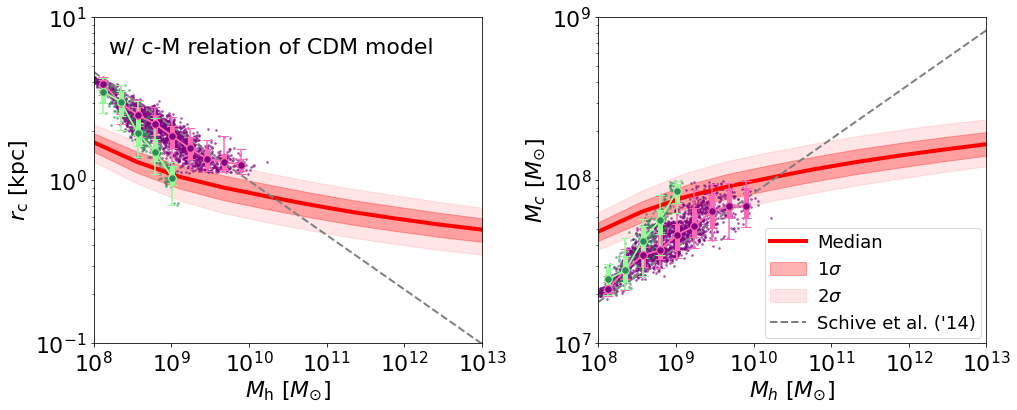

In [37]:
theory_color1 = "red"
cmap = "rainbow"


fig = plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

###########################################################
###########################################################

ax = fig.add_subplot(1,2,1)

ax.set_xlim(8,13)
ax.set_yscale("log")
ax.set_ylim(0.1,10)

ax.plot(np.log10(arr_Mvir), result_rc_CDM_median, "-", c="red", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),result_rc_CDM_1sigma_1,result_rc_CDM_1sigma_2, alpha=0.3, color="red", label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),result_rc_CDM_2sigma_1,result_rc_CDM_2sigma_2, alpha=0.1, color="red", label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir), result_rc_CDM_using_mean_cvir, "-", c="gray", lw=2, label="CDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir), vect_rc_Schive_etal(zred, mphi, arr_Mvir), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.scatter(np.log10(sim_cosmo[:,0]),sim_cosmo[:,2],s=3, color="purple", alpha=0.5)
ax.scatter(np.log10(sim_soliton[:,0]),sim_soliton[:,2],s=3, color="seagreen", alpha=0.5)

##### scatter for cosmological simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),cosmo_err[:,8],yerr=[cosmo_err[:,8]-cosmo_err[:,9],cosmo_err[:,10]-cosmo_err[:,8]], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),cosmo_err[:,8],yerr=[cosmo_err[:,8]-cosmo_err[:,11],cosmo_err[:,12]-cosmo_err[:,8]], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5)

##### scatter for soliton merger simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),soliton_err[:,8],
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[soliton_err[:,8]-soliton_err[:,9],soliton_err[:,10]-soliton_err[:,8]], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),soliton_err[:,8],
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[soliton_err[:,8]-soliton_err[:,11],soliton_err[:,12]-soliton_err[:,8]], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5)

ax.text(8.2, 6, "w/ c-M relation of CDM model", fontsize=22)

ax.set_xlabel("$M_{\\rm h}$ [$M_{\\odot}$]",fontsize=22)
ax.set_ylabel(r"$r_{\rm c}$ [kpc]",fontsize=22)
# ax.legend(loc="upper right",fontsize=16)


name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.tick_params(axis="x",labelsize=22)
ax.tick_params(axis="y",labelsize=22)

###########################################################
###########################################################

ax = fig.add_subplot(1,2,2)

ax.set_xlim(8,13)
ax.set_ylim(7,np.log10(2e8))

ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_CDM_median), "-", c="red", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_CDM_1sigma_1), np.log10(result_Mc_CDM_1sigma_2), alpha=0.3, color="red", label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_CDM_2sigma_1), np.log10(result_Mc_CDM_2sigma_2), alpha=0.1, color="red", label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_CDM_using_mean_cvir), "-", c="gray", lw=2, label="CDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir),np.log10(vect_Mc_Schive_etal(zred, mphi, arr_Mvir)), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.scatter(np.log10(sim_cosmo[:,0]),np.log10(sim_cosmo[:,1]),s=3, color="purple", alpha=0.5)
ax.scatter(np.log10(sim_soliton[:,0]),np.log10(sim_soliton[:,1]),s=3, color="seagreen", alpha=0.5)

##### scatter for cosmological simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),np.log10(cosmo_err[:,3]),
            yerr=[np.log10(cosmo_err[:,3])-np.log10(cosmo_err[:,4]),np.log10(cosmo_err[:,5])-np.log10(cosmo_err[:,3])], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),np.log10(cosmo_err[:,3]),
            yerr=[np.log10(cosmo_err[:,3])-np.log10(cosmo_err[:,6]),np.log10(cosmo_err[:,7])-np.log10(cosmo_err[:,3])], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5)

##### scatter for soliton merger simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),np.log10(soliton_err[:,3]),
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[np.log10(soliton_err[:,3])-np.log10(soliton_err[:,4]),np.log10(soliton_err[:,5])-np.log10(soliton_err[:,3])], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),np.log10(soliton_err[:,3]),
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[np.log10(soliton_err[:,3])-np.log10(soliton_err[:,6]),np.log10(soliton_err[:,7])-np.log10(soliton_err[:,3])], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5)

ax.set_xlabel("$M_h$ $[M_{\\odot}]$",fontsize=22)
ax.set_ylabel("$M_c$ $[M_{\\odot}]$",fontsize=22)
ax.legend(loc="lower right",borderaxespad=0.3, borderpad=0.3, handletextpad=0.6, fontsize=18)

name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.yaxis.set_ticks([7,8,9])
ax.set_yticklabels(["$10^{7}$","$10^{8}$","$10^{9}$"])
ax.tick_params(axis="x",labelsize=22)
ax.tick_params(axis="y",labelsize=22)
ax.yaxis.set_minor_locator(FixedLocator(np.log10([1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8])))


#plt.savefig("Mc_Mvir.pdf", bbox_inches="tight", pad_inches=0.1, transparent=True)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/core_halo_mass_CDM.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/2524566368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)
/var/folders/xp/q_zqsjqn2459gh__nyk7n5xw0000gn/T/ipykernel_63443/2524566368.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)


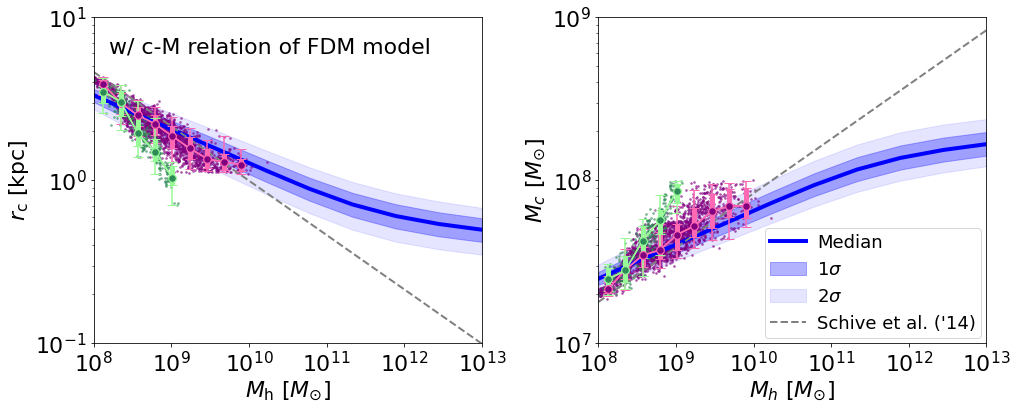

In [42]:
theory_color1 = "blue"
cmap = "rainbow"
fig = plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

###########################################################
###########################################################

ax = fig.add_subplot(1,2,1)

ax.set_xlim(8,13)
ax.set_yscale("log")
ax.set_ylim(0.1,10)

ax.plot(np.log10(arr_Mvir), result_rc_FDM_median, "-", c="blue", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),result_rc_FDM_1sigma_1, result_rc_FDM_1sigma_2, color="blue", alpha=0.3, label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),result_rc_FDM_2sigma_1, result_rc_FDM_2sigma_2, color="blue", alpha=0.1, label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir), result_rc_FDM_using_mean_cvir, "-", c="gray", lw=2, label="FDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir), vect_rc_Schive_etal(zred, mphi, arr_Mvir), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.scatter(np.log10(sim_cosmo[:,0]),sim_cosmo[:,2],s=3, color="purple", alpha=0.5)
ax.scatter(np.log10(sim_soliton[:,0]),sim_soliton[:,2],s=3, color="seagreen", alpha=0.5)

##### scatter for cosmological simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),cosmo_err[:,8],yerr=[cosmo_err[:,8]-cosmo_err[:,9],cosmo_err[:,10]-cosmo_err[:,8]], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),cosmo_err[:,8],yerr=[cosmo_err[:,8]-cosmo_err[:,11],cosmo_err[:,12]-cosmo_err[:,8]], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5)

##### scatter for soliton merger simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),soliton_err[:,8],
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[soliton_err[:,8]-soliton_err[:,9],soliton_err[:,10]-soliton_err[:,8]], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),soliton_err[:,8],
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[soliton_err[:,8]-soliton_err[:,11],soliton_err[:,12]-soliton_err[:,8]], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5)

ax.set_xlabel("$M_{\\rm h}$ [$M_{\\odot}$]",fontsize=22)
ax.set_ylabel(r"$r_{\rm c}$ [kpc]",fontsize=22)
#ax.legend(loc="upper right",fontsize=16)

ax.text(8.2, 6, "w/ c-M relation of FDM model", fontsize=22)


name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.tick_params(axis="x",labelsize=22)
ax.tick_params(axis="y",labelsize=22)

###########################################################
###########################################################


ax = fig.add_subplot(1,2,2)

ax.set_xlim(8,13)
ax.set_ylim(7,np.log10(2e8))

ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_FDM_median), "-", c="blue", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_FDM_1sigma_1), np.log10(result_Mc_FDM_1sigma_2), color="blue", alpha=0.3, label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_FDM_2sigma_1), np.log10(result_Mc_FDM_2sigma_2), color="blue", alpha=0.1, label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_FDM_using_mean_cvir), "-", c="gray", lw=2, label="FDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir),np.log10(vect_Mc_Schive_etal(zred, mphi, arr_Mvir)), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.scatter(np.log10(sim_cosmo[:,0]),np.log10(sim_cosmo[:,1]),s=3, color="purple", alpha=0.5)
ax.scatter(np.log10(sim_soliton[:,0]),np.log10(sim_soliton[:,1]),s=3, color="seagreen", alpha=0.5)

##### scatter for cosmological simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),np.log10(cosmo_err[:,3]),
            yerr=[np.log10(cosmo_err[:,3])-np.log10(cosmo_err[:,4]),np.log10(cosmo_err[:,5])-np.log10(cosmo_err[:,3])], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),np.log10(cosmo_err[:,3]),
            yerr=[np.log10(cosmo_err[:,3])-np.log10(cosmo_err[:,6]),np.log10(cosmo_err[:,7])-np.log10(cosmo_err[:,3])], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5)

##### scatter for soliton merger simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),np.log10(soliton_err[:,3]),
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[np.log10(soliton_err[:,3])-np.log10(soliton_err[:,4]),np.log10(soliton_err[:,5])-np.log10(soliton_err[:,3])], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),np.log10(soliton_err[:,3]),
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[np.log10(soliton_err[:,3])-np.log10(soliton_err[:,6]),np.log10(soliton_err[:,7])-np.log10(soliton_err[:,3])], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5)

ax.set_xlabel("$M_h$ $[M_{\\odot}]$",fontsize=22)
ax.set_ylabel("$M_c$ $[M_{\\odot}]$",fontsize=22)
ax.legend(loc="lower right",borderaxespad=0.3, borderpad=0.3, handletextpad=0.6, fontsize=18)

name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.yaxis.set_ticks([7,8,9])
ax.set_yticklabels(["$10^{7}$","$10^{8}$","$10^{9}$"])
ax.tick_params(axis="x",labelsize=22)
ax.tick_params(axis="y",labelsize=22)
ax.yaxis.set_minor_locator(FixedLocator(np.log10([1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8])))


#plt.savefig("Mc_Mvir.pdf", bbox_inches="tight", pad_inches=0.1, transparent=True)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/core_halo_mass_FDM.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

/var/folders/cb/4q5dpz7x27l204yzpcv4984r0000gn/T/ipykernel_27855/2206366669.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)
/var/folders/cb/4q5dpz7x27l204yzpcv4984r0000gn/T/ipykernel_27855/2206366669.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_x_labels)


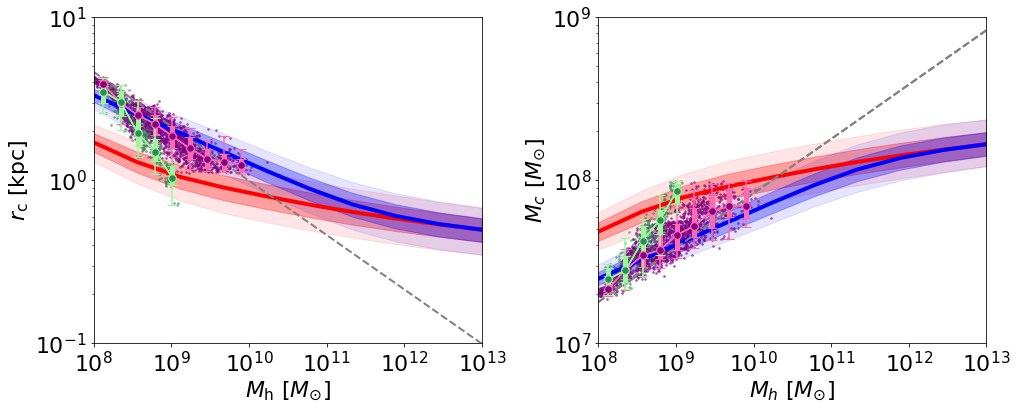

In [104]:
theory_color1 = "red"
cmap = "rainbow"


fig = plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

###########################################################
###########################################################

ax = fig.add_subplot(1,2,1)

ax.set_xlim(8,13)
ax.set_yscale("log")
ax.set_ylim(0.1,10)

ax.plot(np.log10(arr_Mvir), result_rc_CDM_median, "-", c="red", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),result_rc_CDM_1sigma_1,result_rc_CDM_1sigma_2, alpha=0.3, color="red", label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),result_rc_CDM_2sigma_1,result_rc_CDM_2sigma_2, alpha=0.1, color="red", label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir), result_rc_CDM_using_mean_cvir, "-", c="gray", lw=2, label="CDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir), vect_rc_Schive_etal(zred, mphi, arr_Mvir), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.plot(np.log10(arr_Mvir), result_rc_FDM_median, "-", c="blue", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),result_rc_FDM_1sigma_1, result_rc_FDM_1sigma_2, color="blue", alpha=0.3, label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),result_rc_FDM_2sigma_1, result_rc_FDM_2sigma_2, color="blue", alpha=0.1, label="$2\\sigma$")

ax.scatter(np.log10(sim_cosmo[:,0]),sim_cosmo[:,2],s=3, color="purple", alpha=0.5)
ax.scatter(np.log10(sim_soliton[:,0]),sim_soliton[:,2],s=3, color="seagreen", alpha=0.5)

##### scatter for cosmological simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),cosmo_err[:,8],yerr=[cosmo_err[:,8]-cosmo_err[:,9],cosmo_err[:,10]-cosmo_err[:,8]], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),cosmo_err[:,8],yerr=[cosmo_err[:,8]-cosmo_err[:,11],cosmo_err[:,12]-cosmo_err[:,8]], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5)

##### scatter for soliton merger simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),soliton_err[:,8],
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[soliton_err[:,8]-soliton_err[:,9],soliton_err[:,10]-soliton_err[:,8]], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),soliton_err[:,8],
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[soliton_err[:,8]-soliton_err[:,11],soliton_err[:,12]-soliton_err[:,8]], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5)

ax.set_xlabel("$M_{\\rm h}$ [$M_{\\odot}$]",fontsize=22)
ax.set_ylabel(r"$r_{\rm c}$ [kpc]",fontsize=22)
# ax.legend(loc="upper right",fontsize=16)


name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.tick_params(axis="x",labelsize=22)
ax.tick_params(axis="y",labelsize=22)

###########################################################
###########################################################

ax = fig.add_subplot(1,2,2)

ax.set_xlim(8,13)
ax.set_ylim(7,np.log10(2e8))

ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_CDM_median), "-", c="red", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_CDM_1sigma_1), np.log10(result_Mc_CDM_1sigma_2), alpha=0.3, color="red", label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_CDM_2sigma_1), np.log10(result_Mc_CDM_2sigma_2), alpha=0.1, color="red", label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_CDM_using_mean_cvir), "-", c="gray", lw=2, label="CDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir),np.log10(vect_Mc_Schive_etal(zred, mphi, arr_Mvir)), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_FDM_median), "-", c="blue", lw=4, label="Median")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_FDM_1sigma_1), np.log10(result_Mc_FDM_1sigma_2), color="blue", alpha=0.3, label="$1\\sigma$")
ax.fill_between(np.log10(arr_Mvir),np.log10(result_Mc_FDM_2sigma_1), np.log10(result_Mc_FDM_2sigma_2), color="blue", alpha=0.1, label="$2\\sigma$")
# ax.plot(np.log10(arr_Mvir),np.log10(result_Mc_FDM_using_mean_cvir), "-", c="gray", lw=2, label="FDM $r_{\\rm c}(\\langle c_{\\rm vir}\\rangle)$")
ax.plot(np.log10(arr_Mvir),np.log10(vect_Mc_Schive_etal(zred, mphi, arr_Mvir)), "--", color="gray", lw=2, label="Schive et al. ('14)")

ax.scatter(np.log10(sim_cosmo[:,0]),np.log10(sim_cosmo[:,1]),s=3, color="purple", alpha=0.5)
ax.scatter(np.log10(sim_soliton[:,0]),np.log10(sim_soliton[:,1]),s=3, color="seagreen", alpha=0.5)

##### scatter for cosmological simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),np.log10(cosmo_err[:,3]),
            yerr=[np.log10(cosmo_err[:,3])-np.log10(cosmo_err[:,4]),np.log10(cosmo_err[:,5])-np.log10(cosmo_err[:,3])], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(cosmo_err[:,0]),np.log10(cosmo_err[:,3]),
            yerr=[np.log10(cosmo_err[:,3])-np.log10(cosmo_err[:,6]),np.log10(cosmo_err[:,7])-np.log10(cosmo_err[:,3])], marker='.', 
            color="hotpink", mfc='purple', ms=15, capsize=5)

##### scatter for soliton merger simulations ######
#/// 1sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),np.log10(soliton_err[:,3]),
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[np.log10(soliton_err[:,3])-np.log10(soliton_err[:,4]),np.log10(soliton_err[:,5])-np.log10(soliton_err[:,3])], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5, elinewidth=5)
#/// 2sigma ///#
ax.errorbar(np.log10(soliton_err[:,0]),np.log10(soliton_err[:,3]),
            # xerr=[np.log10(soliton_err[:,0])-np.log10(soliton_err[:,1]),np.log10(soliton_err[:,2])-np.log10(soliton_err[:,0])],
            yerr=[np.log10(soliton_err[:,3])-np.log10(soliton_err[:,6]),np.log10(soliton_err[:,7])-np.log10(soliton_err[:,3])], marker='.', 
            color="palegreen", mfc='seagreen', ms=15, capsize=5)

ax.set_xlabel("$M_h$ $[M_{\\odot}]$",fontsize=22)
ax.set_ylabel("$M_c$ $[M_{\\odot}]$",fontsize=22)
#ax.legend(loc="lower right",borderaxespad=0.3, borderpad=0.3, handletextpad=0.6, fontsize=18)

name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
ax.set_xticklabels(name_x_labels)
ax.yaxis.set_ticks([7,8,9])
ax.set_yticklabels(["$10^{7}$","$10^{8}$","$10^{9}$"])
ax.tick_params(axis="x",labelsize=22)
ax.tick_params(axis="y",labelsize=22)
ax.yaxis.set_minor_locator(FixedLocator(np.log10([1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8])))


#plt.savefig("Mc_Mvir.pdf", bbox_inches="tight", pad_inches=0.1, transparent=True)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/core_halo_mass_CDM.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

## <font color="Red">Get inner slope dependence of core-halo relation in the limit of $c_{\rm vir}\to0$</font>

### Set cosmological parameters

In [ ]:
##### Mass of FDM #####

mphi = 8.e-23

##### Redshift #####

zred = 0

##### Cosmological parameters #####

hubble = 0.677
Omegam0 = 0.276
Omegab0 = 0.02258/hubble**2
OmegaCDM0 = Omegam0 - Omegab0
OmegaL0 = 1-Omegam0
sigma_8 = 0.8

rho_crit0 = 2.77536627e11
rho_m0 = Omegam0*rho_crit0 # in unit h^{2} Msun/Mpc^{3}

### Definitions 

In [11]:
#############################################
#####  Cosmology dependent functions   ######
#############################################

#### (Redshift dependent) matter density parameter ####

def Omegam(z):
    return (1+z)**3 * Omegam0/((1+z)**3 * Omegam0 + OmegaL0)

#### Virial overdensity ####

def Deltavir(z):
    result = 18*np.pi**2 + 82*(Omegam(z)-1)-39*(Omegam(z)-1)**2
    result = result/Omegam(z)
    return result

In [7]:
from scipy.special import beta, gamma

def R_s(s):   # the argument s must be less than 2 and larger than 0, i.e., 0<=s<2.
    vv = 1/(2-s)
    xx = -1/(4-s)
    yy = -s/3/(4-s)
    zz = (2-s)/(4-s)
    AA = 4/3/np.pi * ((3-s)*(2-s))**vv * beta(1/(2-s), 3/2) / (2-s)
    return np.sqrt(6)*(8* np.pi/3*(3-s))**xx * (3/4/np.pi)**yy * AA**zz 

def T_s(s):
    vv = 1/(2-s)
    xx =-1/(4-s)
    zz = (2-s)/(4-s)
    BB = ((3-s)*(2-s))**vv * beta(1/(2-s), 3/2) / (2-s) *4/3/np.pi
    return 49.064*(721.305*(3-s))**xx * BB**zz

func_Rs = np.vectorize(R_s)
func_Ts = np.vectorize(T_s)


def r_core_limit_GENERAL(s, m_FDM, mass, z):  # in units of k[
    zz = 1/(4-s)
    mm = -2/(4-s)
    qq = -s/3/(4-s)
    rr = -(1-s/3)/(4-s)
#    result = 3.59161 * (1+zred)**(-2./3.) * (mphi/1e-22)**(-2./3.) * (Mvir/1e9)**(-1.0/9.0) * (Deltavir(zred)/200)**(-2.0/9.0) * (Omegam0*hubble**2/0.147)**(-2.0/9.0)
    result = T_s(s) * (1+z)**zz * (m_FDM/1e-22)**mm * (mass/1e9)**qq * (Deltavir(z)/200)**rr * (Omegam0*hubble**2/0.147)**rr
    return result

def r_core_limit(mass, z):
    result = 3.59161 * (1+z)**(-2./3.) * (m_FDM/1e-22)**(-2./3.) * (mass/1e9)**(-1.0/9.0) * (Deltavir(z)/200)**(-2.0/9.0) * (Omegam0*hubble**2/0.147)**(-2.0/9.0)
    return result


vect_r_core_limit = np.vectorize(r_core_limit)
vect_r_core_limit_GENERAL = np.vectorize(r_core_limit_GENERAL)

def Mc_limit_GENERAL(s, m_FDM, mass, z):
    rc       = r_core_limit_GENERAL(s, m_FDM, mass, z)         # in units of kpc
    rhoc     = 1.9*(1+z)*(m_FDM/1e-23)**(-2)*rc**(-4) # in units of M_sun / kpc**3
    result   = 4*(np.pi)*0.2225*rhoc*rc**3 *1e9         # in units of M_sun
    return result

vect_Mc_limit_GENERAL = np.vectorize(Mc_limit_GENERAL)


In [4]:
def alpha(z, m_FDM, mass, cvir):
    result = 7.213e4 * (mphi/1e-21)**2 * (mass/1e9)**(4.0/3.0) * (Deltavir(zred)/200)**(-1.0/3.0) * (Omegam0*hubble**2/0.147)**(-1.0/3.0) * fcvir(cvir)/(1+zred)
    return result
vect_alpha = np.vectorize(alpha)

### Results: Figs. 13 & 14

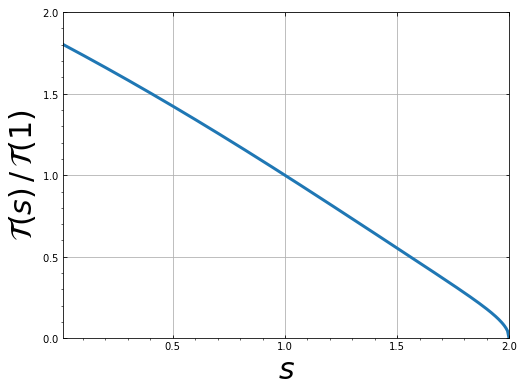

In [5]:
smin=0.01
smax=2.0
nmax=300
ss = np.linspace(smin, smax-0.001, nmax)
baseline = np.zeros(nmax)


ymin=0
ymax=2.0

plt.rcParams["font.size"] = 25
fig=plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(1,1,wspace=0.0,hspace=0.0)

ax = plt.subplot(gs[0,0])
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.tick_params(direction='in',bottom=True,left=True,right=True,top=True)
ax.tick_params(labelbottom=True,labelleft=True,labelright=False,labeltop=False)
ax.set_xticks(np.linspace(0, 2, 5))
ax.set_yticks(np.arange(ymin, ymax+0.001, (ymax-ymin)/4))
ax.set_xlabel('$s$',fontsize=30)
# ax.set_ylabel('$\\mathcal{R}(s)\\,/\\,\\mathcal{R}(1)$,  $\\mathcal{T}(s)\\,/\\,\\mathcal{T}(1)$',fontsize=40)
# ax.plot(ss,   func_Rs(ss)/R_s(1), ls='--', lw=5, color='tab:blue', label="$\\mathcal{R}(s)\\,/\\,\\mathcal{R}(1)$")
ax.set_ylabel('$\\mathcal{T}(s)\\,/\\,\\mathcal{T}(1)$',fontsize=30)
ax.plot(ss,   func_Ts(ss)/T_s(1), ls='-', lw=3) #, color='tab:red')
# ax.plot(ss,   func_T2s(ss)/T2_s(1), ls='-', lw=5, color='tab:green', label="$\\mathcal{T}(s)\\,/\\,\\mathcal{T}(1)$")
# ax.text(0.015, ymin+0.1*(ymax-ymin), "$\\alpha=$%2.1e"%alpha, color='black', fontsize=35)
#ax.text(0.085, ymin+0.9*(ymax-ymin), "Dashed: trucation at $r_{vir}$", color='black', fontsize=25)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

ax.set_xlim(smin,smax)
ax.set_ylim(ymin,ymax)
ax.grid()
ax.minorticks_on()
#ax.legend(shadow=True,loc='upper right',fontsize=35,handletextpad=0.5,handlelength= 1.5, borderaxespad=0.5)
plt.show()

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/func_Rs.pdf')
# pp.savefig(fig)
# pp.close()

/var/folders/cb/4q5dpz7x27l204yzpcv4984r0000gn/T/ipykernel_5580/3154076807.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$'])
/var/folders/cb/4q5dpz7x27l204yzpcv4984r0000gn/T/ipykernel_5580/3154076807.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  bx.set_xticklabels(['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$'])


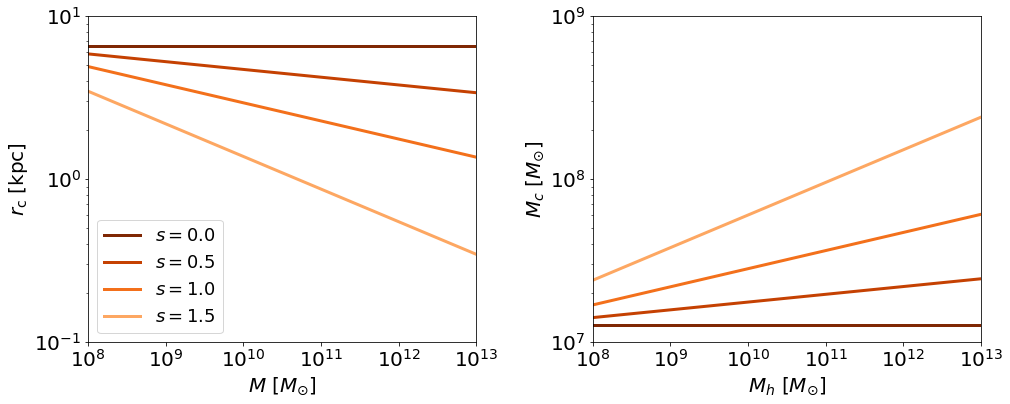

In [12]:
cmb = plt.get_cmap("Oranges")

fig = plt.figure(figsize=(16,6))

arr_Mvir = np.logspace(8.0, 13.0, num=10)

plt.subplots_adjust(wspace=0.3, hspace=0.6)


ax = fig.add_subplot(1,2,1)
ax.set_xlim(8,13)
ax.set_yscale("log")
ax.set_ylim(0.1,10)

ax.set_xlabel("$M$ [$M_{\\odot}$]",fontsize=20)
ax.set_ylabel(r"$r_{\rm c}$ [kpc]",fontsize=20)

for i in range(4):
    ss = 0.5*i
    ax.plot(np.log10(arr_Mvir),vect_r_core_limit_GENERAL(ss, mphi, arr_Mvir,0.0), "-", color=cmb(1-0.2*i), lw=3, label="$s=%2.1f$"%ss)

ax.set_xticklabels(['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$'])
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

ax.legend(loc="lower left",fontsize=18)


bx = fig.add_subplot(1,2,2)

bx.set_xlim(8,13)
bx.set_ylim(7,np.log10(2e8))

for i in range(4):
    ss = 0.5*i
    bx.plot(np.log10(arr_Mvir),np.log10(vect_Mc_limit_GENERAL(ss,mphi, arr_Mvir,0.0)), "-", color=cmb(1-0.2*i), lw=3, label="$s=%2.1f$"%ss)
    
bx.set_xlabel("$M_h$ $[M_{\\odot}]$",fontsize=20)
bx.set_ylabel("$M_c$ $[M_{\\odot}]$",fontsize=20)

# name_x_labels = ['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$']
# bx.set_xticklabels(name_x_labels)
bx.set_xticklabels(['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$'])
bx.yaxis.set_ticks([7,8,9])
bx.set_yticklabels(["$10^{7}$","$10^{8}$","$10^{9}$"])
bx.tick_params(axis="x",labelsize=20)
bx.tick_params(axis="y",labelsize=20)
bx.yaxis.set_minor_locator(FixedLocator(np.log10([1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8])))
#bx.legend(loc="upper right",fontsize=16)

plt.show()

#plt.savefig("Mc_Mvir.pdf", bbox_inches="tight", pad_inches=0.1, transparent=True)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/core_halo_mass_FDM_limit.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

/var/folders/cb/4q5dpz7x27l204yzpcv4984r0000gn/T/ipykernel_5580/3927586459.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$'])


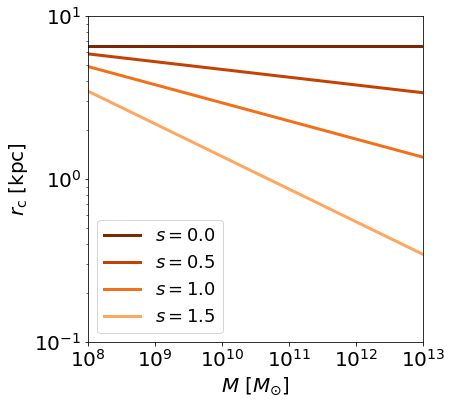

In [28]:
cmb = plt.get_cmap("Oranges")

fig = plt.figure(figsize=(6,6))

arr_Mvir = np.logspace(8.0, 13.0, num=10)

#plt.subplots_adjust(wspace=0.3, hspace=0.6)


ax = fig.add_subplot(1,1,1)
ax.set_xlim(8,13)
ax.set_yscale("log")
ax.set_ylim(0.1,10)

ax.set_xlabel("$M$ [$M_{\\odot}$]",fontsize=20)
ax.set_ylabel(r"$r_{\rm c}$ [kpc]",fontsize=20)

for i in range(4):
    ss = 0.5*i
    ax.plot(np.log10(arr_Mvir),vect_r_core_limit_GENERAL(ss, mphi, arr_Mvir,0.0), "-", color=cmb(1-0.2*i), lw=3, label="$s=%2.1f$"%ss)

ax.set_xticklabels(['$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$','$10^{12}$','$10^{13}$'])
ax.tick_params(axis="x",labelsize=20)
ax.tick_params(axis="y",labelsize=20)

ax.legend(loc="lower left",fontsize=18)


plt.show()

#plt.savefig("Mc_Mvir.pdf", bbox_inches="tight", pad_inches=0.1, transparent=True)

## Output to PDF file
# pp = PdfPages('/Users/ataruya/Files/Lin/work_space/FDM/draft/Figs/core_radius_halo_mass_cvir0limit.pdf')
# pp.savefig(fig, bbox_inches='tight')
# pp.close()